In [1]:
import sys
sys.path.append('helpers/')

from pprint import pprint
import scipy.io as scio
from torch.utils.data import Dataset, DataLoader
from eegdProcessors import getLabeledEpochs, DownSample, BPButter4, F_RemoveOutliers, Normalise, getEpochsDataFromRaw, dataToListOfEpochs
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torchvision import transforms
import torch.optim as optim
import torch.nn.functional as F

In [2]:
eeg_1s_raw = scio.loadmat('./data/subject_1_eeg_separated_epochs_1s.mat')

In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [4]:
# Definiranje klase pyTorch dataseta za eeg podatke

class eegDataset(Dataset):
    labels = ('Target', 'non Target')

    def __init__(self, target, nontarget, ratio, seed, transform=None, filterChain = []):
        self.epochs = getLabeledEpochs(target, nontarget, ratio, seed=seed, filterChain=filterChain)
        self.transform = transform

    def __len__(self):
        return len(self.epochs)

    def __getitem__(self, idx):
        label = self.epochs[idx][0]
        epoch = self.epochs[idx][1]

        # Ako je dan transformer podataka
        # poslati podatke kroz njega
        if self.transform:
            epoch = self.transform(epoch)

        return torch.from_numpy(np.expand_dims(epoch, axis=0)), label

In [5]:
## Odvajanje podataka za treniranje i testiranje

# Iscitavanje 'data' polja iz .mat datoteke
target_data = getEpochsDataFromRaw(eeg_1s_raw, 0)
nonTarget_data = getEpochsDataFromRaw(eeg_1s_raw, 1)

# Formatiranje podataka tako da budu kao lista epoha
# iteriranje je onda po [epoh, elektroda, sample]
# npr. ako trazimo epoh 3: epoh3 = target_epochs[2]
# dobiti ce se dvodimenzionalni array pa recimo svi samplovi mjerenja elektrode 8: epoh3[7]
target_epochs = dataToListOfEpochs(target_data)
nonTarget_epochs = dataToListOfEpochs(nonTarget_data)

print("Target full shape", target_epochs.shape)
print("Target TRAINING shape", target_epochs[: int(target_epochs.shape[0]*0.7) ].shape)
print("Target TESTING shape", target_epochs[ int(target_epochs.shape[0]*0.7): ].shape)

TRAINING_target_epochs = target_epochs[: int(target_epochs.shape[0]*0.7) ]
TESTING_target_epochs = target_epochs[ int(target_epochs.shape[0]*0.7): ]

print("--------------")
print("Target full shape", nonTarget_epochs.shape)
print("Target TRAINING shape", nonTarget_epochs[: int(nonTarget_epochs.shape[0]*0.7) ].shape)
print("Target TESTING shape", nonTarget_epochs[ int(nonTarget_epochs.shape[0]*0.7): ].shape)

TRAINING_nonTarget_epochs = nonTarget_epochs[: int(nonTarget_epochs.shape[0]*0.7) ]
TESTING_nonTarget_epochs = nonTarget_epochs[ int(nonTarget_epochs.shape[0]*0.7): ]

Target full shape (305, 16, 512)
Target TRAINING shape (213, 16, 512)
Target TESTING shape (92, 16, 512)
--------------
Target full shape (6447, 16, 512)
Target TRAINING shape (4512, 16, 512)
Target TESTING shape (1935, 16, 512)


In [6]:
len(getLabeledEpochs(TESTING_target_epochs, TESTING_nonTarget_epochs, 1/5, filterChain=[F_RemoveOutliers(200)]))

552

In [7]:
# Definiranje dataloadera

downsapling = 1
# Prvo se podatci downsampleaju downsapling puta
# zatim se filtriraju PP Butt filtrom 4. reda od 0.1hz do 20hz
# zatim se podatci normaliziraju po (pdf: CNN for P300 Detec... sekcija 3.1 na stranici 436)

print()

training_data = eegDataset(TRAINING_target_epochs, TRAINING_nonTarget_epochs, 1/5, 'abc', transform=transforms.Compose([
    DownSample(downsapling),
    BPButter4(0.1, 20, 512/downsapling),
    Normalise()
]), filterChain=[
    F_RemoveOutliers(200)
])
train_dataloader = DataLoader(training_data, batch_size=4, shuffle=True)


testing_data = eegDataset(TESTING_target_epochs, TESTING_nonTarget_epochs, 1/5, 'abc', transform=transforms.Compose([
    DownSample(downsapling),
    BPButter4(0.1, 20, 512/downsapling),
    Normalise()
]), filterChain=[
    F_RemoveOutliers(200)
])
testing_dataloader = DataLoader(testing_data, batch_size=4, shuffle=True)


In [8]:
print(len(train_dataloader.dataset.epochs))
print(train_dataloader.dataset.epochs[0][1].shape)

print(len(testing_dataloader.dataset.epochs))
print(testing_dataloader.dataset.epochs[0][1].shape)

1236
(16, 512)
552
(16, 512)


Feature batch shape: torch.Size([4, 1, 16, 512])
Labels batch shape: torch.Size([4])


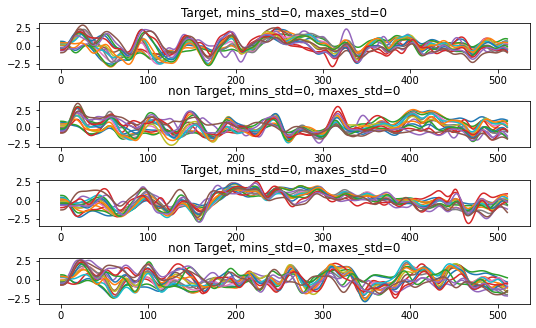

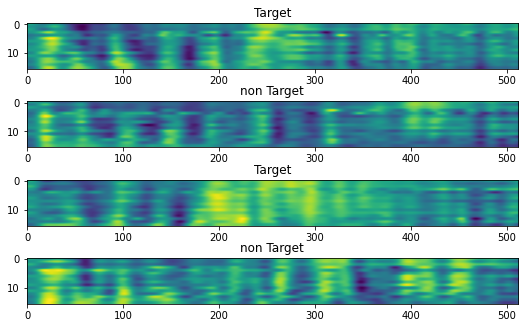

In [9]:
# Vizualizacija jednog batcha

train_ephs, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_ephs.size()}")
print(f"Labels batch shape: {train_labels.size()}")

fig2, ax2 = plt.subplots(len(train_ephs))
for key, itm in enumerate(train_ephs):
    item = itm[0]
    # Racunanje standardne devijacije maximuma i minimuma mjerenja elektroda
    mins = []
    maxes = []
    for line in item:
        ax2[key].plot(line)
        mins.append(line.min())
        maxes.append(line.max())
    mins = np.array(mins)
    maxes = np.array(maxes)
    label = training_data.labels[train_labels[key]] + ", mins_std=" + str(int(mins.std())) + ", maxes_std=" + str(int(maxes.std()))
    ax2[key].set_title(label)
    ax2[key].set_aspect('auto')

fig2.set_figwidth(2.2*len(train_ephs))
fig2.set_figheight(len(train_ephs))
fig2.subplots_adjust(top=1.1, hspace=0.7)



fig, ax = plt.subplots(len(train_ephs))
for key, itm in enumerate(train_ephs):
    item = itm[0]
    label = training_data.labels[train_labels[key]]
    ax[key].set_title(label)
    ax[key].imshow(item)
    ax[key].set_aspect('auto')

fig.set_figwidth(2.2*len(train_ephs))
fig.set_figheight(len(train_ephs))
fig.subplots_adjust(top=1.1, hspace=0.7)



In [10]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()

        self.F1 = 8
        self.F2 = 16
        self.D = 2
        
        # Conv2d(in,out,kernel,stride,padding,bias)
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, 8), padding=(0, 32), bias=False),
            nn.BatchNorm2d(self.F1)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(self.F1, self.D*self.F1, (4, 1), groups=self.F1, bias=False),
            nn.BatchNorm2d(self.D*self.F1),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.5)
        )
        
        self.Conv3 = nn.Sequential(
            nn.Conv2d(self.D*self.F1, self.D*self.F1, (1, 16), padding=(0, 8), groups=self.D*self.F1, bias=False),
            nn.Conv2d(self.D*self.F1, self.F2, (1, 1), bias=False),
            nn.BatchNorm2d(self.F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(0.5)
        )
        
        self.classifier = nn.Linear(16*13*17, 9*4, bias=True)
        self.classifier2 = nn.Linear(9*4, 1, bias=True)
        # self.classifier3 = nn.Linear(2, 2, bias=True)
        
    def forward(self, x):
        
        x = self.conv1(x.float())
        # print(x.shape)
        x = self.conv2(x.float())
        # print(x.shape)
        x = self.Conv3(x.float())
        # print(x.shape)
        
        x = x.view(-1, 16*13*17)
        # print(x.shape)
        x = self.classifier(x.float())
        x = F.relu(x)
        x = self.classifier2(x.float())
        # x = self.classifier3(x.float())
        x = torch.sigmoid(x)
        # print(x.shape)
        return x

In [11]:
eegnet = EEGNet().to(device).float()
criterion = nn.BCELoss()
optimizer = optim.SGD(eegnet.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
# Treniranje

from re import I
lossPoints = []
for epoch in range(300):

    running_loss = 0.0
    lencntr = 0
    for i, data in enumerate(train_dataloader, 0):
        print ("batch: " + str(i), end="\r")
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        lencntr += 1

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = eegnet(inputs)
        # print(outputs)
        loss = criterion(outputs, labels.reshape(-1,1).float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    ttloss = running_loss/lencntr
    lossPoints.append(ttloss)
    print('epoch: %d, totLoss=%.3f' % (epoch+1, ttloss))

print('Finished Training')
torch.save(eegnet.state_dict(), 'savedModel')

Text(0, 0.5, 'Loss')

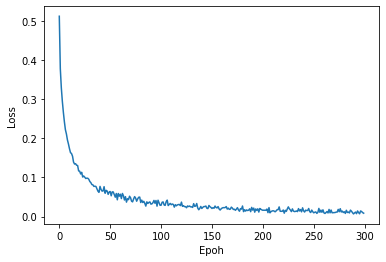

In [13]:
plt.plot(lossPoints)
plt.xlabel('Epoh')
plt.ylabel('Loss')

In [14]:
from sklearn import metrics

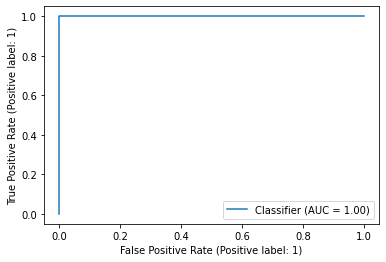

In [15]:
def runOnTrainingData():
	# tocno = 0
	total = 0
	y_true_tensor = []
	y_pred_tensor = []
	with torch.no_grad():
		for data in train_dataloader:
			inputs, labels = data
			inputs = inputs.to(device)
			labels = labels.to(device)

			outs = eegnet(inputs)

			# Prikupljanje podataka za ROC krivulju
			for label, prediction in zip(labels, outs):
				y_true_tensor.append(label)
				y_pred_tensor.append(prediction)

			# torch.max(tensor, 1) vraca poziciju neurona na kojemu je max vrijednost
			# _, predicted = torch.max(outs.data, 1)
			total += labels.size(0)
			# tocno += (predicted == labels).sum().item()
			print ("klasificiram uzorak: " + str(total), end="\r")

	y_true = []
	y_pred = []

	for label, prediction in zip(y_true_tensor, y_pred_tensor):
		y_true.append(label.item())
		y_pred.append(prediction.cpu().detach().numpy())


	metrics.RocCurveDisplay.from_predictions(y_true, y_pred)

runOnTrainingData()

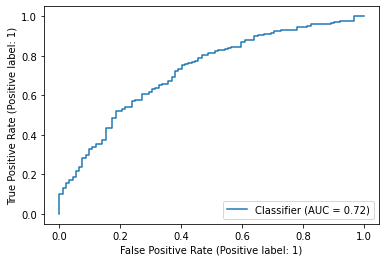

In [20]:
def runOnTestingData():
	# tocno = 0
	total = 0
	y_true_tensor = []
	y_pred_tensor = []
	with torch.no_grad():
		for data in testing_dataloader:
			inputs, labels = data
			inputs = inputs.to(device)
			labels = labels.to(device)

			outs = eegnet(inputs)

			# Prikupljanje podataka za ROC krivulju
			for label, prediction in zip(labels, outs):
				y_true_tensor.append(label)
				y_pred_tensor.append(prediction)

			# torch.max(tensor, 1) vraca poziciju neurona na kojemu je max vrijednost
			# _, predicted = torch.max(outs.data, 1)
			total += labels.size(0)
			# tocno += (predicted == labels).sum().item()
			print ("klasificiram uzorak: " + str(total), end="\r")

	y_true = []
	y_pred = []

	for label, prediction in zip(y_true_tensor, y_pred_tensor):
		y_true.append(label.item())
		y_pred.append(prediction.cpu().detach().numpy())


	metrics.RocCurveDisplay.from_predictions(y_true, y_pred)

runOnTestingData()